In [1]:
import pickle
from scipy.spatial import distance
from time import time
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from joblib import Parallel, delayed
%matplotlib inline

In [2]:
with open("../data/LFW_DATA.pickle", "rb") as f:
    lfw = pickle.load(f)

In [3]:
lfw["database_identity"]

array([[array(['Aaron_Eckhart\\Aaron_Eckhart_0001.jpg'], dtype='<U36')],
       [array(['Aaron_Guiel\\Aaron_Guiel_0001.jpg'], dtype='<U32')],
       [array(['Aaron_Patterson\\Aaron_Patterson_0001.jpg'], dtype='<U40')],
       ...,
       [array(['Zumrati_Juma\\Zumrati_Juma_0001.jpg'], dtype='<U34')],
       [array(['Zurab_Tsereteli\\Zurab_Tsereteli_0001.jpg'], dtype='<U40')],
       [array(['Zydrunas_Ilgauskas\\Zydrunas_Ilgauskas_0001.jpg'], dtype='<U46')]],
      dtype=object)

In [4]:
print("data_feature shape:",lfw["database_feature"].shape)

data_feature shape: (13113, 4720)


In [5]:
def l2_distance1(a, b):
    dst = distance.euclidean(a,b)
    return dst

def l2_distance2(a, b):
    dist = np.linalg.norm(a-b)
    return dist

In [6]:
a = lfw["database_feature"][0]
b = lfw["database_feature"][1]
start_time = time()
for i in range(100000):
    l2_distance1(a,b)
end_time = time()
end_time - start_time

4.820364236831665

In [7]:
start_time = time()
for i in range(100000):
    l2_distance2(a,b)
end_time = time()
end_time - start_time

1.909254550933838

numpy function is faster than scipy for computing l2 distance

In [8]:
def search(query_feature,database_feature, identity, dist_metric="l2"):
    distance_list = []
    a = query_feature
    if  dist_metric == "l2":
        for b in database_feature:
            distance_list.append(l2_distance1(a, b))
    elif dist_metric=="spearmanr":
        for b in database_feature:
            dist = scipy.stats.spearmanr(a,b)[0]
            distance_list.append(dist)
    elif dist_metric=="minkowski":
        for b in database_feature:
            X = np.vstack((a,b))
            dist = scipy.spatial.distance.pdist(X, dist_metric,p=1)[0]
            distance_list.append(dist)
    elif dist_metric=="overlap":
        query_feature[query_feature!=0] = 1
        database_feature[database_feature!=0] = 1
        for b in database_feature:
            X = np.vstack((a,b))
            dist = scipy.spatial.distance.pdist(X, "cosine")[0]
            distance_list.append(dist)
    else:
        for b in database_feature:
            X = np.vstack((a,b))
            dist = scipy.spatial.distance.pdist(X, dist_metric)[0]
            distance_list.append(dist)
            
    sortIndexByDist = np.argsort(np.array(distance_list))
    return identity[sortIndexByDist]

In [9]:
# input query
query_index = 8
query_feature = lfw["query_feature"][query_index]
query_identity = lfw["query_identity"][query_index]
print("query image:",query_identity)
database_feature = lfw["database_feature"]
identity = lfw["database_identity"]
response = search(query_feature, database_feature, identity, dist_metric="minkowski")

query image: [array(['Ariel_Sharon\\Ariel_Sharon_0009.jpg'], dtype='<U34')]


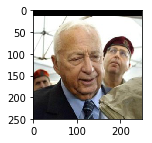

In [10]:
def show_image(identity):
    file_name = identity[0][0].replace("\\","/")
    image_dir = "../data/lfw_image/"
    image_path = os.path.join(image_dir,file_name)
    query_image = imageio.imread(image_path)
    plt.figure(figsize=(2,2))
    plt.imshow(query_image)
    plt.show()

show_image(query_identity)

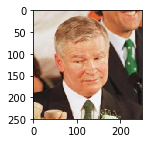

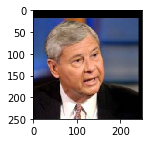

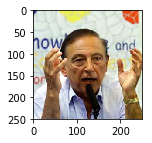

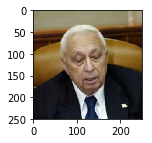

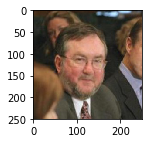

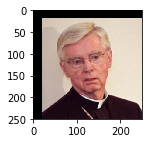

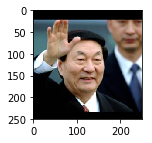

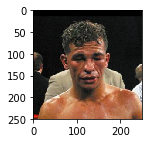

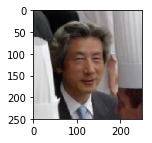

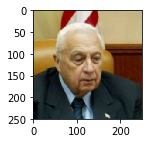

In [11]:
# show top 10 retrival results
for _id in response[:10]:
    show_image(_id)

# Performance evaluation

In [12]:
# calculate MAP
def p(k, query_identity, response):
#     precision at k
    query_name = query_identity[0][0].split("\\")[0]
    retrieved_name = np.array([response[i][0][0].split("\\")[0] for i in range(len(response))])
    correct = sum(query_name==retrieved_name[:k])
    return correct/k

def AveP(query_identity, response, identity):
    # aompute average precision
    query_name = query_identity[0][0].split("\\")[0]
    database_name = np.array([identity[i][0][0].split("\\")[0] for i in range(len(identity))])
    retrieved_name = np.array([response[i][0][0].split("\\")[0] for i in range(len(response))])
    number_of_relevance = sum(query_name == database_name)
#     print("number of relevance ",number_of_relevance)
    numerator = []
    for k in range(number_of_relevance):
        if retrieved_name[k] == query_name:
            rel = 1
        else:
            rel = 0
        score = p(k+1,query_identity,response)*rel
        numerator.append(score)
    return sum(numerator)/number_of_relevance


def MAP(numberOfQuery,AveP_list):
    return sum(AveP_list)/numberOfQuery

In [13]:
print("P@10:",p(10, query_identity=query_identity, response=response))

P@10: 0.2


In [14]:
print("average precision:", AveP(query_identity, response, identity))

average precision: 0.04202929926892368


In [15]:
# use all queries for evaluation
dist_metrics = ["l2", "cosine","dice","correlation","minkowski",
                "sqeuclidean"]
def compute(query_index, AveP_list):
    query_feature = lfw["query_feature"][query_index]
    query_identity = lfw["query_identity"][query_index]
#     print("query image:",query_identity[0][0].split("\\")[0])
    database_feature = lfw["database_feature"]
    identity = lfw["database_identity"]
    response = search(query_feature, database_feature, identity, dist_metric=metric)
    ave_precision = AveP(query_identity, response, identity)
#     print(ave_precision)
#     print()
    AveP_list.append(ave_precision)
    return AveP_list

for metric in dist_metrics:
    print("distance metric:",metric)
    AveP_list = []
    AveP_list = Parallel(n_jobs=20)(delayed(compute)(query_index,AveP_list) for query_index in range(len(lfw["query_identity"])))
    AveP_list = np.array(AveP_list).flatten()
    print("MAP on {} queries {}:\n".format(len(lfw["query_identity"]),
                                              MAP(len(lfw["query_identity"]),AveP_list)))

distance metric: l2
MAP on 120 queries 0.0736463179995979:

distance metric: cosine
MAP on 120 queries 0.09825315243156758:

distance metric: dice
MAP on 120 queries 0.09189496185349881:

distance metric: correlation
MAP on 120 queries 0.09746979135692227:

distance metric: minkowski
MAP on 120 queries 0.1245680655007643:

distance metric: sqeuclidean
MAP on 120 queries 0.07364519225011859:



#  Sparse coding

1. Dictionary training<br><img src="../images/eq1.png" width="320"></img>
2. Codeword assignment<br><img src="../images/eq2.png" width="320"></img>

In [16]:
import spams

In [17]:
def dictionary_learning(patch_feature, lambda1=1, dictionary_size=100, batchsize=100,
                       posD=True):
    # input shape (feature size, sample size)
    X_patch = np.asfortranarray(patch_feature)
    param = { 'K' : dictionary_size, # learns a dictionary with 400 elements
             "mode":0,
              'lambda1' : lambda1, 'numThreads' : -1,
             "batchsize":batchsize,
             'posD':posD
            }
    D = spams.trainDL_Memory(X_patch,**param)
    return D

def sparse_feature_coding(patch_feature, dictionary, lambda1=1, pos=True):
    # lasso
    param = {
        'lambda1' : lambda1, # not more than 20 non-zeros coefficients
        'numThreads' : -1, 
        'mode' : 0, # penalized formulation
        'pos' : pos
    } 
    X_patch = np.asfortranarray(patch_feature)
    alpha = spams.lasso(X_patch, D = D, return_reg_path = False, **param)
    dense_alpha = scipy.sparse.csr_matrix.todense(alpha)
    return dense_alpha

In [18]:
X = np.array(lfw["database_feature"])
print(X.shape)
X_patch = np.asfortranarray(X[:,:59]) # change type to Fortran array
print(X_patch.shape)

(13113, 4720)
(13113, 59)


In [19]:
X_split = np.split(X,80, axis=1) # split to 80 patch
print(len(X_split))
print(X_split[0].shape)

80
(13113, 59)


In [31]:
# Hyper-parameter
BATCHSIZE = 100
DICTIONARY_SIZE = 100
POS_D_CONSTRAINT =  True
POS_LARS_CONSTRAINT =  True
LAMBDA_DL = 1
LAMBDA_LARS = 1

# train 80 different dictionaries for all parts in the faces
D_list = []
alpha_list = []
patch = 0
for single_patch in X_split:
    patch+=1
    X_patch = single_patch.T
    if patch%10 == 0:
        print("patch:",patch)
    # learn dictionary for single patch
    D = dictionary_learning(X_patch,
                            lambda1=LAMBDA_DL, 
                            dictionary_size=DICTIONARY_SIZE,
                            batchsize=BATCHSIZE, 
                            posD=POS_D_CONSTRAINT)
    alpha = sparse_feature_coding(X_patch, D, 
                                  lambda1=LAMBDA_LARS, 
                                  pos=POS_LARS_CONSTRAINT).T
    D_list.append(D)
    alpha_list.append(alpha)

sparse_database_feature = np.concatenate(np.array(alpha_list),axis=1) 
print("sparse database shape:",sparse_database_feature.shape)

patch: 10
patch: 20
patch: 30
patch: 40
patch: 50
patch: 60
patch: 70
patch: 80
sparse database shape: (13113, 8000)


In [32]:
# sparse encode query feature
X_query = lfw["query_feature"]
# train 80 different dictionaries for all parts in the faces
alpha_list = []
patch = 0
dictionary_index = 0
X_query_split = np.split(X_query,80, axis=1)
for single_patch in X_query_split:
    patch+=1
    D = D_list[dictionary_index]
    dictionary_index += 1
    X_patch = np.asfortranarray(single_patch).T
    if patch%10 == 0:
        print("patch:",patch, "dictionary_index:",dictionary_index)
    # learn dictionary for single patch
    
    alpha = sparse_feature_coding(X_patch, D, lambda1=LAMBDA_LARS, pos=POS_LARS_CONSTRAINT).T
    alpha_list.append(alpha)
sparse_query_feature = np.concatenate(np.array(alpha_list),axis=1) 
print("sparse query shape",sparse_query_feature.shape)

patch: 10 dictionary_index: 10
patch: 20 dictionary_index: 20
patch: 30 dictionary_index: 30
patch: 40 dictionary_index: 40
patch: 50 dictionary_index: 50
patch: 60 dictionary_index: 60
patch: 70 dictionary_index: 70
patch: 80 dictionary_index: 80
sparse query shape (120, 8000)


In [50]:
# identity embedding
database_id_list = np.array([lfw["database_identity"][i][0][0].split("\\")[0] for i in range(len(lfw["database_identity"]))])

database_id_uni = np.array(sorted(list(set(database_id_list))))
print("have {} different names in database".format(len(database_id_uni)))
sparse_database_feature_identity = np.copy(sparse_database_feature)
weight = 0.
for identity in database_id_uni:
    id_mask = database_id_list == identity
    sub_feature = sparse_database_feature[id_mask]
    id_mean_feature = sub_feature.mean(axis=0)
    sparse_database_feature_identity[id_mask,:] = sparse_database_feature[id_mask,:]*weight + \
    id_mean_feature*(1-weight)

have 5749 different names in database


In [51]:
# use all queries for evaluation
dist_metrics = ["overlap","cosine","l2", "dice","correlation","minkowski"]
# dist_metrics = ["overlap","cosine"]
def compute(query_index,AveP_list):
    query_feature = sparse_query_feature[query_index]
    query_identity = lfw["query_identity"][query_index]
    database_feature = sparse_database_feature_identity
    identity = lfw["database_identity"]
    response = search(query_feature, database_feature, identity, dist_metric=metric)
    ave_precision = AveP(query_identity, response, identity)
    AveP_list.append(ave_precision)
    return AveP_list

# experiment
print("beta:{}, lambda DL:{}, lambda LARS:{}, batch size:{}, dictionary size:{}, postiveD:{}, postiveLARS:{}".format(
    weight ,LAMBDA_DL, LAMBDA_LARS, BATCHSIZE, DICTIONARY_SIZE, POS_D_CONSTRAINT, POS_LARS_CONSTRAINT))
for metric in dist_metrics:
    print("distance metric:",metric)
    AveP_list = []
    AveP_list = Parallel(n_jobs=20)(delayed(compute)(query_index,AveP_list) for query_index in range(len(lfw["query_identity"])))
    AveP_list = np.array(AveP_list).flatten()
    print("MAP on {} queries {}".format(len(lfw["query_identity"]),
                                              MAP(len(lfw["query_identity"]),AveP_list)))

beta:0.0, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.783541557779899
distance metric: l2
MAP on 120 queries 0.7812835327159214
distance metric: dice
MAP on 120 queries 0.0
distance metric: correlation
MAP on 120 queries 0.7483135031137272
distance metric: minkowski
MAP on 120 queries 0.3643913567254549


batch size:256, dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.04094575444624592:
distance metric: cosine
MAP on 120 queries 0.03590309257256008:
distance metric: l2
MAP on 120 queries 0.03466738221684197:
distance metric: dice
MAP on 120 queries 0.040948053149307315:
distance metric: correlation
MAP on 120 queries 0.035896799409168:
distance metric: minkowski
MAP on 120 queries 0.03572459968977103:



batch size:1000, dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.03676895065154161:
distance metric: cosine
MAP on 120 queries 0.0350202754820454:
distance metric: l2
MAP on 120 queries 0.03214556637415699:
distance metric: dice
MAP on 120 queries 0.03676895065154161:
distance metric: correlation
MAP on 120 queries 0.03498706754543817:
distance metric: minkowski
MAP on 120 queries 0.03497815517593576:

batch size:32, dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.0354102010792405:
distance metric: cosine
MAP on 120 queries 0.03392073856784808:
distance metric: l2
MAP on 120 queries 0.031062089934471994:
distance metric: dice
MAP on 120 queries 0.0354102010792405:
distance metric: correlation
MAP on 120 queries 0.033886812378462944:
distance metric: minkowski
MAP on 120 queries 0.03397668360368808:

*lAMBDA 都等於1*
batch size:256, dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.059701905837829465:
distance metric: cosine
MAP on 120 queries 0.04636592660930212:
distance metric: l2
MAP on 120 queries 0.0007049393450897742:
distance metric: dice
MAP on 120 queries 0.05571725238049626:
distance metric: correlation
MAP on 120 queries 0.04587222066799389:
distance metric: minkowski
MAP on 120 queries 0.0006358256855701084:


lambda DL:1, lambda LARS:1, batch size:256,       dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.12556867668142788
distance metric: cosine
MAP on 120 queries 0.06435418110431676
distance metric: l2
MAP on 120 queries 0.008656220280467586
distance metric: dice
MAP on 120 queries 0.12562589119760237
distance metric: correlation
MAP on 120 queries 0.0632715313280919
distance metric: minkowski
MAP on 120 queries 0.025824743451290367

lambda DL:1, lambda LARS:0.1, batch size:100,dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.0644645480037463
distance metric: cosine
MAP on 120 queries 0.04456849417788473
distance metric: l2
MAP on 120 queries 0.009437361896055119
distance metric: dice
MAP on 120 queries 0.06446925703121278
distance metric: correlation
MAP on 120 queries 0.04436709657639091
distance metric: minkowski
MAP on 120 queries 0.045332862850662785

lambda DL:1, lambda LARS:10, batch size:100,dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.12338911223506685

lambda DL:1, lambda LARS:1, batch size:100,dictionary size:100, postive:True
distance metric: overlap
MAP on 120 queries 0.11945286664437794

lambda DL:1, lambda LARS:1, batch size:400,dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.11658606786653304

lambda DL:1, lambda LARS:1, batch size:32,dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.12375854787442873

lambda DL:1, lambda LARS:1, batch size:256,dictionary size:400, postive:False
distance metric: overlap
MAP on 120 queries 0.11318694480315486

lambda DL:1, lambda LARS:1, batch size:100,dictionary size:100, postive:False
distance metric: overlap
MAP on 120 queries 0.12757783529922576

lambda DL:1, lambda LARS:1, batch size:100,dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.12422211793773087


#### sparse with identity
beta:0.5, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.23450512804733678

beta:0.15, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.6304253452062618

beta:0.75, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.11504667695722882

beta:0.25, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.49691516636214444

beta:0.1, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.6994632950268033
distance metric: l2
MAP on 120 queries 0.6888171749208084
distance metric: dice
MAP on 120 queries 0.0
distance metric: correlation
MAP on 120 queries 0.681891819321934
distance metric: minkowski
MAP on 120 queries 0.34930472225867487

beta:0.01, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.7769745761915757
distance metric: l2
MAP on 120 queries 0.7703551535778504
distance metric: dice
MAP on 120 queries 0.0
distance metric: correlation
MAP on 120 queries 0.7495604243058221
distance metric: minkowski
MAP on 120 queries 0.36447519966076575

beta:0.0, lambda DL:1, lambda LARS:1, batch size:100, dictionary size:100, postiveD:True, postiveLARS:True
distance metric: overlap
MAP on 120 queries 0.4033193950544718
distance metric: cosine
MAP on 120 queries 0.783541557779899
distance metric: l2
MAP on 120 queries 0.7812835327159214
distance metric: dice
MAP on 120 queries 0.0
distance metric: correlation
MAP on 120 queries 0.7483135031137272
distance metric: minkowski
MAP on 120 queries 0.3643913567254549

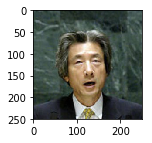

In [71]:
query_index = 99
query_feature = sparse_query_feature[query_index]
query_identity = lfw["query_identity"][query_index]
database_feature = sparse_database_feature_identity
identity = lfw["database_identity"]
response = search(query_feature, database_feature, identity, dist_metric="cosine")
show_image(query_identity)

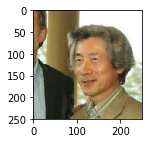

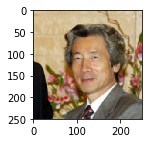

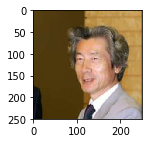

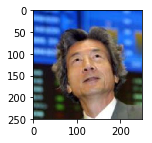

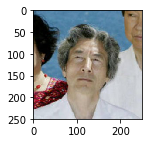

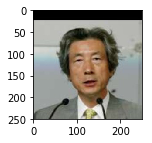

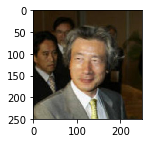

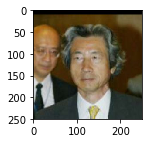

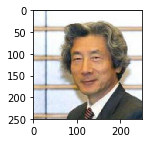

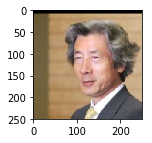

In [72]:
for _id in response[:10]:
    show_image(_id)